In [2]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.test.is_gpu_available())


TensorFlow version: 2.20.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available: False


In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt

def load_img(path): #for loading image function
    img=tf.io.read_file(path)
    img=tf.image.decode_image(img,channels=3)
    img=tf.image.convert_image_dtype(img,tf.float32)

    img=tf.image.resize(img,(512,512)) #resizing for fast processin
    img=img[tf.newaxis,:]
    return img

def show_img(image,title='Image'): #func to disp images
    image=tf.squeeze(image,axis=0)
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    

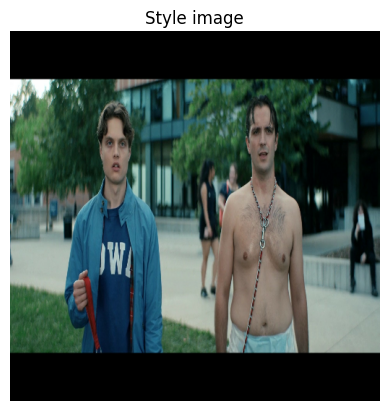

In [7]:
content_imag=load_img("content.jpg")
style_imag=load_img("style.jpg")

show_img(content_imag,"Content Image")
show_img(style_imag,"Style image")

In [10]:
vgg = tf.keras.applications.VGG19(include_top=False,weights="imagenet") #loading vgg19 wite pretrained imagenet weights
vgg.trainable=False

style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1',
]

content_layers = ['block5_conv2'] #layers for content extraction
output_layers = style_layers + content_layers
model = tf.keras.Model(
    inputs=vgg.input,
    outputs=[vgg.get_layer(name).output for name in output_layers]

)

print("Model is Ready. Exctracting style and content features....")


Model is Ready. Exctracting style and content features....


In [11]:
#Function to load and preprocess image
def load_and_process_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (512, 512))
    img = img[tf.newaxis, :]
    return img

#Function to deprocess image
def deprocess_image(img):
    img = img[0]
    img = tf.clip_by_value(img, 0.0, 1.0)
    img = tf.image.convert_image_dtype(img, tf.uint8)
    return img

#Gram Matrix to capture style
def gram_matrix(tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', tensor, tensor)
    num_locations = tf.cast(tensor.shape[1] * tensor.shape[2], tf.float32)
    return result / num_locations


In [12]:
def get_feature_representation(model,content_path,style_path):
    content_imag= load_and_process_image(content_path)
    style_imag = load_and_process_image(style_path)

    style_outputs = model(style_imag)
    content_outputs = model(content_imag)

    style_features = [gram_matrix(style_layers) for style_layers in style_outputs[:len(style_layers)]]
    content_features= content_outputs[len(style_layers):]
    return style_features,content_features,content_image


In [26]:
# Loss calculation
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):

    style_weight, content_weight = loss_weights

    model_outputs = model(init_image)

    style_output_features = model_outputs[:len(style_layers)]
    content_output_features = model_outputs[len(style_layers):]

    # Style loss
    style_score = 0
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        comb_style_gram = gram_matrix(comb_style)
        style_score += tf.reduce_mean(tf.square(comb_style_gram - target_style))

    style_score /= len(style_layers)

    # Content loss
    content_score = 0
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += tf.reduce_mean(tf.square(comb_content - target_content))

    content_score /= len(content_layers)

    # Total loss
    total_loss = style_weight * style_score + content_weight * content_score
    return total_loss

def compute_loss_and_grads(model, optimizer, loss_weights, init_image, gram_style_features, content_features):
    with tf.GradientTape() as tape:
        loss = compute_loss(
            model,
            loss_weights,
            init_image,
            gram_style_features,
            content_features
        )

    grads = tape.gradient(loss, init_image)  # compute gradients
    optimizer.apply_gradients([(grads, init_image)])  # update image
    init_image.assign(tf.clip_by_value(init_image, 0.0, 1.0))  # keep values between 0–1

    return loss, init_image


In [16]:
def get_feature_representations(model, content_path, style_path):
    # Load images
    content_image = load_img(content_path)
    style_image = load_img(style_path)

    # Extract content and style features
    style_outputs = model(style_image)
    content_outputs = model(content_image)

    # Separate style and content layers output
    style_features = [style_layer for style_layer in style_outputs[:len(style_layers)]]
    content_features = [content_layer for content_layer in content_outputs[len(style_layers):]]

    # Convert style feature maps to gram matrices
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

    return gram_style_features, content_features, content_image


In [19]:
# Training settings
opt = tf.optimizers.Adam(learning_rate=5.0)
style_weight = 1e-2
content_weight = 1e4
content_path = 'content.jpg'
style_path = 'style.jpg'

# Extract features
gram_style_features, content_features, content_image = get_feature_representations(model, content_path, style_path)

# Start image as content
init_image = tf.Variable(content_image, dtype=tf.float32)

# Config
cfg = {
    'model': model,
    'loss_weights': (style_weight, content_weight),
    'init_image': init_image,
    'gram_style_features': gram_style_features,
    'content_features': content_features
}

# Training loop
epochs = 200
for i in range(epochs):
    grads, loss = compute_grads(cfg)
    opt.apply_gradients([(grads, init_image)])

    if i % 20 == 0:
        print(f"Iteration {i}, Loss: {loss}")


Iteration 0, Loss: 3.0726966857910156
Iteration 20, Loss: 33161.6484375
Iteration 40, Loss: 6860.5517578125
Iteration 60, Loss: 3916.492919921875
Iteration 80, Loss: 3449.63134765625
Iteration 100, Loss: 3761.854248046875
Iteration 120, Loss: 3873.24267578125
Iteration 140, Loss: 3984.63330078125
Iteration 160, Loss: 4649.70751953125
Iteration 180, Loss: 5036.5576171875


In [27]:
optimizer = tf.optimizers.Adam(learning_rate=0.03)

epochs = 5
steps_per_epoch = 100

loss_weights = (style_weight, content_weight)

best_loss = float('inf')
best_img = None

print("Training Started...\n")

for epoch in range(epochs):
    for step in range(steps_per_epoch):
        loss, init_image = compute_loss_and_grads(
            model, optimizer, loss_weights, init_image,
            gram_style_features, content_features
        )

        if loss < best_loss:
            best_loss = loss
            best_img = init_image.numpy()

        if step % 25 == 0:
            print(f"Epoch {epoch+1}, Step {step}, Loss: {loss.numpy():.4f}")

print("\nTraining Complete!")


Training Started...

Epoch 1, Step 0, Loss: 4241.8525
Epoch 1, Step 25, Loss: 805.0642
Epoch 1, Step 50, Loss: 462.0477
Epoch 1, Step 75, Loss: 331.2102
Epoch 2, Step 0, Loss: 268.9738
Epoch 2, Step 25, Loss: 224.2590
Epoch 2, Step 50, Loss: 203.7113
Epoch 2, Step 75, Loss: 174.7417
Epoch 3, Step 0, Loss: 164.0147
Epoch 3, Step 25, Loss: 151.0829
Epoch 3, Step 50, Loss: 155.0022
Epoch 3, Step 75, Loss: 134.7220
Epoch 4, Step 0, Loss: 117.6642
Epoch 4, Step 25, Loss: 123.0226
Epoch 4, Step 50, Loss: 120.0148
Epoch 4, Step 75, Loss: 110.6540
Epoch 5, Step 0, Loss: 121.3080
Epoch 5, Step 25, Loss: 103.6138
Epoch 5, Step 50, Loss: 93.1422
Epoch 5, Step 75, Loss: 90.5350

Training Complete!


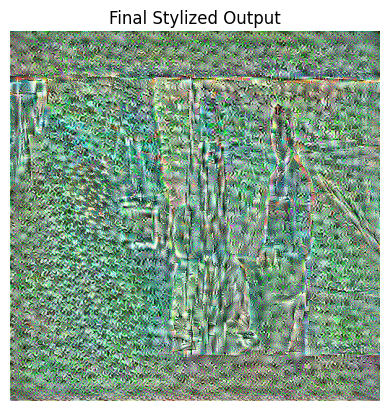

In [28]:
show_img(best_img, "Final Stylized Output")


In [36]:
import numpy as np
def tensor_to_image(image):
    # If it's already numpy, no need to convert
    if hasattr(image, "numpy"):
        image = image.numpy()
    
    # Remove batch dimension if exists (shape: (1, H, W, C))
    if image.ndim == 4:
        image = np.squeeze(image, axis=0)
    
    # Clip values correctly
    image = np.clip(image, 0.0, 1.0)

    # Convert to uint8 format
    image = (image * 255).astype(np.uint8)
    return image


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

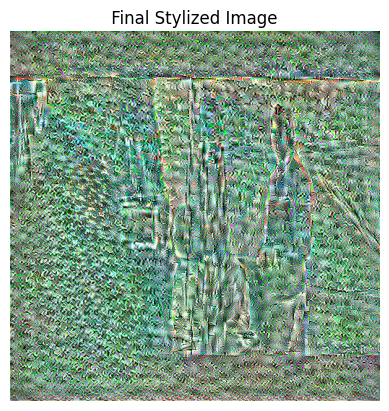

In [37]:
final_img = tensor_to_image(best_img)
plt.imshow(final_img)
plt.title(" Final Stylized Image ")
plt.axis("off")
